In [1]:
import torch
import os

os.chdir('../')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from itertools import chain
from rdkit.Chem import Descriptors
from src.tacogfn.utils import misc, molecules, sascore

Get generated results

In [3]:
ref_fps = misc.get_reference_fps()

In [4]:
benchmark_res = torch.load('misc/benchmarking/pocket2mol_res.pt')

In [5]:
pharmaco_res_path = 'misc/evaluations/20240117_alpha_default_evaluated.json'
with open(pharmaco_res_path) as f:
    pharmaco_res = json.load(f)

In [6]:
benchmark_eval = {}

for pocket, val in tqdm(benchmark_res.items()):
    smiles = val["smiles"]

    mols = [Chem.MolFromSmiles(smi) for smi in smiles]

    qeds = [Descriptors.qed(mol) for mol in mols]
    sas = [(10.0 - sascore.calculateScore(mol)) / 9 for mol in mols]
    diversity = molecules.compute_diversity(mols)
    novelty = molecules.compute_novelty(mols, ref_fps)

    benchmark_eval[pocket] = {
        "smiles": smiles,
        "qeds": qeds,
        "sas": sas,
        "diversity": diversity,
        "novelty": novelty,
    }

100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


In [7]:
benchmark_novelty = list(chain.from_iterable([v["novelty"] for k, v in benchmark_eval.items()]))

In [8]:
benchmark_diversity = list(chain.from_iterable([v["diversity"] for k, v in benchmark_eval.items()]))

In [9]:
pharmaco_novelty = list(chain.from_iterable([v["novelty"] for k, v in pharmaco_res.items()]))

In [10]:
pharmaco_diversity = list(chain.from_iterable([v["diversity"] for k, v in pharmaco_res.items()]))

In [43]:
import pandas as pd
import seaborn as sns

# create a dictionary to map categories to labels
category_labels = {'Benchmark': 'Benchmark', 'Pharmaco': 'Pharmaco'}

data = pd.DataFrame({
    'Method': ['Pocket2Mol'] * len(benchmark_novelty) + ['PharmacoGFN'] * len(pharmaco_novelty),
    'Novelty': benchmark_novelty + pharmaco_novelty,
})

# sns.set_theme(style="whitegrid")

# ax = sns.violinplot(x="Method", y="Novelty", data=data, palette="Set2", cut=0, inner='quartile', linewidth=1)

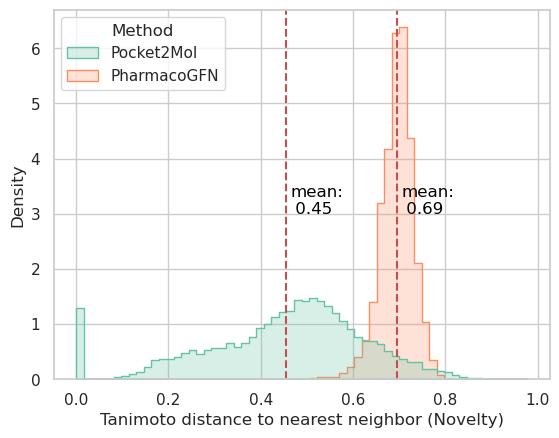

In [71]:
sns.set_theme(style="whitegrid")

ax = sns.histplot(x="Novelty", hue="Method", data=data, palette="Set2", element="step", stat='density')
ax.set_xlabel('Tanimoto distance to nearest neighbor (Novelty)')
ax.set_ylabel('Density')

# Calculate the mean values for each group
mean_values = data.groupby('Method')['Novelty'].mean()

# Draw vertical lines at the mean values and write the mean value on the plot
for method, mean in mean_values.items():
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean ({method})')
    ax.annotate(f'mean:\n {mean:.2f}', xy=(mean, 0.5), xytext=(mean + 0.01, 3), color='black')

# ax.set_xticklabels(['Benchmark', 'Pharmaco'])

In [72]:
import seaborn as sns

# create a dictionary to map categories to labels
category_labels = {'Benchmark': 'Benchmark', 'Pharmaco': 'Pharmaco'}

data = pd.DataFrame({
    'Method': ['Pocket2Mol'] * len(benchmark_diversity) + ['PharmacoGFN'] * len(pharmaco_diversity),
    'Diversity': benchmark_diversity + pharmaco_diversity,
})

PharmacoGFN mean: 0.73
Pocket2Mol mean: 0.75


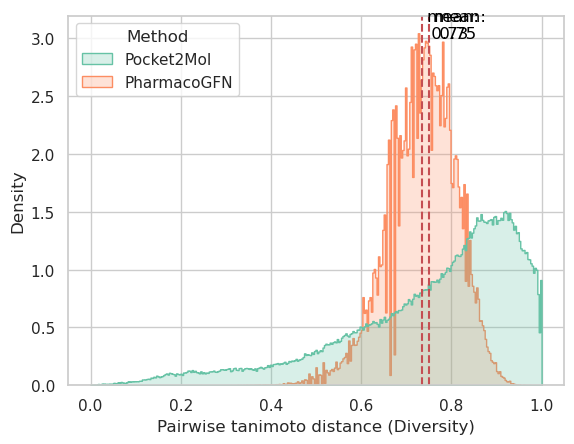

In [75]:
sns.set_theme(style="whitegrid")

ax = sns.histplot(x="Diversity", hue="Method", data=data, palette="Set2", element="step", stat='density')
ax.set_xlabel('Pairwise tanimoto distance (Diversity)')
ax.set_ylabel('Density')

# Calculate the mean values for each group
mean_values = data.groupby('Method')['Diversity'].mean()

# Draw vertical lines at the mean values and write the mean value on the plot
for method, mean in mean_values.items():
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean ({method})')
    ax.annotate(f'mean:\n {mean:.2f}', xy=(mean, 0.5), xytext=(mean + 0.01, 3), color='black')
    print(f'{method} mean: {mean:.2f}')


In [15]:
# import numpy as np
# dock = False

# all_vals = {
#     'qeds': [],
#     'sas': [],
#     'diversity': [],
#     'novelty': [],
# }
# if dock:
#     all_vals['docking_scores'] = []


# for key, val in evaluated_results.items():
#     all_vals['qeds'].append(np.mean(val['qeds']))
#     all_vals['sas'].append(np.mean(val['sas']))
#     all_vals['diversity'].append(np.mean(val['diversity']))
#     all_vals['novelty'].append(np.mean(val['novelty']))
#     if dock:
#         all_vals['docking_scores'].extend([v for v in val['docking_scores'] if v < 0])

In [16]:
# np.mean(all_vals['novelty'])

0.4509861315074474

In [23]:
# all_vals['novelty'].index(np.min(all_vals['novelty']))

11

In [76]:
from fcd import get_fcd, load_ref_model,canonical_smiles, get_predictions, calculate_frechet_distance

model = load_ref_model()

In [77]:
crossdock = torch.load("dataset/crossdock_docking_scores/all_crossdock_100k.pt")
crossdock_smiles = list(set([v[1] for v in crossdock]))

In [80]:
from rdkit import Chem

benchmark_smis = list(chain.from_iterable([v['smiles'] for _, v in benchmark_res.items()]))
benchmark_mols = [Chem.MolFromSmiles(s) for s in benchmark_smis]

In [115]:
p_smi = list(chain.from_iterable([v['smiles'] for _, v in pharmaco_res.items()]))
p_mols = [Chem.MolFromSmiles(m) for m in p_smi]
p_fps = np.array([list(Chem.RDKFingerprint(m)) for m in p_mols])

In [84]:
act0 = get_predictions(model, crossdock_smiles)
act1 = get_predictions(model, benchmark_smis)
act2 = get_predictions(model, p_smi)

In [116]:
pocket2mol_fps = np.array([list(Chem.RDKFingerprint(m)) for m in benchmark_mols])

In [117]:
ref_fps = np.array([list(k) for k in ref_fps])

In [130]:
import umap

reducer = umap.UMAP(n_components=2)
# from sklearn import manifold

# reducer = manifold.TSNE(n_components=2, random_state=0)

In [131]:
features = reducer.fit_transform(np.vstack([act0, act1, act2]))

# features = reducer.fit_transform(np.vstack([p_fps, pocket2mol_fps, ref_fps]))

In [132]:
# gen_features = reducer.transform()

In [133]:
# gen_features.shape

In [134]:
# p_features = reducer.transform(act2)

In [135]:
# all_features = np.concatenate([features, gen_features, p_features])

<Axes: >

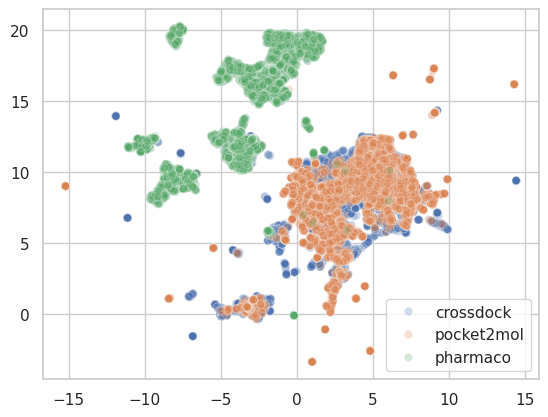

In [136]:
# scatter plot of the 2-dimensional features with seaborn

import seaborn as sns
# name each scatter plot its source 

sns.scatterplot(x=features[:,0], y=features[:,1], hue=['crossdock']*len(act0) + ['pocket2mol']*len(act1) + ['pharmaco']*len(act2), alpha=0.25)


In [25]:
len(evaluated_results[11]['smiles'])

100

In [7]:
import numpy as np
for key, val in all_vals.items():
    print(key, np.mean(val), np.median(val))

qeds 0.5643521763341997 0.5754560084755495
sas 0.7506811622943664 0.7595498695643985
diversity 0.7423542547925785 0.7748222413765954
novelty 0.4509861315074474 0.4639609831490686


In [8]:
num_dups = [v['num_dups'] for k, v in generated_results.items()]
num_dups = [v for v in num_dups if v is not None]
np.mean(num_dups), np.median(num_dups)

(47.42424242424242, 31.0)